# May 31: Save for another paper

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pickle
import seaborn as sns
import geopandas as gpd
from scipy.stats import pearsonr
from shapely import wkt
import math
import plotly.figure_factory as ff

pd.set_option('display.max_colwidth', 0)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pyproj
from fastkml import kml
from shapely.geometry import Point
from shapely.ops import transform

p = pyproj.Transformer.from_crs("EPSG:4326", "EPSG:3857", always_xy=True)

def convert_to_projected(x, lat, lon):
    point = Point(float(x[lon]), float(x[lat]))
    projected_point = transform(p.transform, point)
    x[lat], x[lon] = projected_point.y, projected_point.x
    return x

In [3]:
# SQL engine
from trino.dbapi import connect 
from sqlalchemy import create_engine

class TrinoEngine():
    def __init__(self):
        conn = connect(
            host="localhost",
            port=9090,
            catalog="cuebiq"
        )
        self.cur = conn.cursor()
        self.engine = create_engine("trino://localhost:9090/cuebiq/")
    
    def execute_statement(self, query:str) -> list:
        """
        Create and drop statements.
        """
        self.cur.execute(query)
        return self.cur.fetchall()
    
    def read_sql(self, query:str) -> pd.DataFrame: 
        """
        Select and insert into operations.
        """
        return pd.read_sql(query, self.engine)

sql_engine = TrinoEngine()

# Extract centroids from CBG as approximate home location

In [4]:
%%time
# read CA CBG data
cbg_geom = sql_engine.read_sql(
    f"""
    select
        geography_id, geometry_wkt
    from cuebiq.paas_cda_pe_v3.geography_registry
    where
        country_code = 'US'
        and geography_type_code = 'admin4'
        and geography_id like 'US.CA.%'
    """
)

cbg_geom.rename(columns={'geography_id': 'block_group_id'}, inplace=True)
cbg_geom.geometry_wkt = cbg_geom.geometry_wkt.apply(lambda x: wkt.loads(str(x)))
gdf_CBG = gpd.GeoDataFrame(cbg_geom, geometry=cbg_geom['geometry_wkt'])
gdf_CBG.geometry = gdf_CBG.representative_point()
gdf_CBG['home_lon'] = gdf_CBG['geometry'].x
gdf_CBG['home_lat'] = gdf_CBG['geometry'].y
# gdf_CBG.plot()
print(gdf_CBG.shape[0]) #23212 CBG in CA
gdf_CBG.head(1)

23212
CPU times: user 3.32 s, sys: 60.8 ms, total: 3.38 s
Wall time: 2min 27s


,block_group_id,geometry_wkt,geometry,home_lon,home_lat
0,US.CA.001.451300.2,"POLYGON ((-121.790821 37.688359, -121.790813 37.68901200000001, -121.8008 37.688992, -121.800547 37.687649, -121.801948 37.684033, -121.801196 37.682516, -121.800346 37.682762, -121.790921 37.682886, -121.790821 37.688359))",POINT (-121.79606 37.68584),-121.796057,37.685841


# Assign each person their home location

In [1]:
home_diversity = pd.read_pickle("./output/CA_CBG_dominantRace.pkl") # for the whole California
print('CA CBG home diversity:',home_diversity.shape[0])
home_diversity = home_diversity[home_diversity['scaled_entropy'].notna()]
print('CA CBG home diversity after removing NA:',home_diversity.shape[0])

df_indi_home_loc_race = pd.read_pickle("./output/CA_Individual_race_composition.pkl") # for the whole California
df_indi_home_loc_race = df_indi_home_loc_race[['cuebiq_id','home_block']]
df_indi_home_loc_race = df_indi_home_loc_race.rename(columns={'home_block':'block_group_id'})

df_indi_home_loc_race = pd.merge(df_indi_home_loc_race,gdf_CBG[['block_group_id','home_lon','home_lat']],on=['block_group_id'])
print('after merge with CA CBG:',df_indi_home_loc_race.shape[0])

df_indi_home_loc_race = pd.merge(df_indi_home_loc_race,home_diversity[['block_group_id','class_dominant']],on=['block_group_id'])
print('after merge with CA CBG diversity:',df_indi_home_loc_race.shape[0])
print(df_indi_home_loc_race.class_dominant.value_counts())
df_indi_home_loc_race.head()

# Assign each POI their initial dominant diversity/race group based on the CBG they located in 

In [8]:
df_poi_CBG = pd.read_pickle('./output/LA_POI_belong_CBG.pkl') # each POI belongs to which CBG
df_poi_CBG_merged = pd.merge(df_poi_CBG,home_diversity,on='block_group_id')
df_poi_CBG_mergedneed = df_poi_CBG_merged[['place_id','scaled_entropy','class_dominant']]
df_poi_CBG_mergedneed.rename(columns={'scaled_entropy': 'home_scaled_entropy','class_dominant':'home_class_dominant'}, inplace=True)
df_poi_CBG_mergedneed.head() # each POI's home based diversity

,place_id,home_scaled_entropy,home_class_dominant
0,25609839,0.096533,R_HispanicLatinx_low diversity
1,31157976,0.096533,R_HispanicLatinx_low diversity
2,27287495,0.096533,R_HispanicLatinx_low diversity
3,25590381,0.472712,R_HispanicLatinx_moderate diversity
4,25105312,0.472712,R_HispanicLatinx_moderate diversity


Read in entropy database

In [9]:
#1. proportion based entropy
# diversity_morning = pd.read_pickle("./output/LA_POI_diversity_202203_weekday_morning.pkl")  
# diversity_noon = pd.read_pickle("./output/LA_POI_diversity_202203_weekday_noon.pkl")
# diversity_afternoon = pd.read_pickle("./output/LA_POI_diversity_202203_weekday_afternoon.pkl")
# diversity_evening = pd.read_pickle("./output/LA_POI_diversity_202203_weekday_evening.pkl")
# print(diversity_morning.shape[0],diversity_noon.shape[0],diversity_afternoon.shape[0],diversity_evening.shape[0])
diversity_day = pd.read_pickle("./output/LA_POI_diversity_202203_weekday.pkl")  
print(diversity_day.shape[0])
diversity_day_withhome = pd.merge(diversity_day,df_poi_CBG_mergedneed,how='left')
print(diversity_day_withhome.shape[0])

48731
48731


In [12]:
# for those people live in high diversity CBG, how far they travel to diversity CBG.
# diversity_morning_withhome = diversity_morning_withhome[diversity_morning_withhome['home_class_dominant']=='high diversity']
# print(diversity_morning_withhome.shape[0])
# diversity_morning_withhome['class_dominant'].value_counts()

# e.g., for those origin from high diversity CBG and end up in high diversity POI, how their trip distance look like

In [ ]:
# %%time
# date = ['20220301_20220308','20220309_20220316','20220317_20220323','20220324_20220331']
# weekendays = [20220305,20220306,20220312,20220313,20220319,20220320,20220326,20220327]
# sum_df_race = pd.DataFrame()
# print('weekday:',weekday,',',timeofday,'*'*10)
# for d in date:
#     df_visit_LA = pd.read_pickle("./output/LA_visit_with_poiCategory"+str(d)+".pkl")
    
#     if weekday:#1. select weekdays
#         df_visit_LA = df_visit_LA[~df_visit_LA.event_date.isin(weekendays)]        
#     else:#2. select weekends
#         df_visit_LA = df_visit_LA[df_visit_LA.event_date.isin(weekendays)] 
#     df_visit_LA.drop_duplicates(keep='last', inplace=True)

In [11]:
%%time
weekendays = [20220305,20220306,20220312,20220313,20220319,20220320,20220326,20220327]
df_visit_LA = pd.read_pickle("./output/LA_visit_with_poiCategory20220301_20220308.pkl")
df_visit_LA = df_visit_LA[~df_visit_LA.event_date.isin(weekendays)]
# df_visit_LA = df_visit_LA[(df_visit_LA.start_hour<=10)&(df_visit_LA.end_hour>=5)]
print('original count of visits:',df_visit_LA.shape[0])
# df_visit_LA.head()

# assign each visit their home location and diversity group, consider the whole California
df_visit_LA_merge = pd.merge(df_visit_LA,df_indi_home_loc_race,on=['cuebiq_id']) 
df_visit_LA_merge = df_visit_LA_merge.rename(columns={'class_dominant':'home_class_dominant'})
print('after merge with home location & diversity:',df_visit_LA_merge.shape[0])
# *** (May 31,2023) ***
# Note 1: the smaller count is bc for those visits that are from people outside CA, we do not know their home and home CBG diversity
# for this dataset (20220301_20220308 weekdays), (1528693-1434792)/1528693 = 6.14% are from outside CA

df_visit_LA_merge = pd.merge(df_visit_LA_merge,diversity_day_withhome[['place_id','class_dominant']],on=['place_id'])
print(df_visit_LA_merge.shape[0])

original count of visits: 1528693
after merge with home location & diversity: 1434792
1434790
CPU times: user 5.91 s, sys: 883 ms, total: 6.79 s
Wall time: 6.8 s


In [2]:
%%time
#compute distance between POI and home
df_visit_LA_merge = df_visit_LA_merge.apply(lambda x: convert_to_projected(x, 'poi_lat', 'poi_lng'), axis=1)
df_visit_LA_merge = df_visit_LA_merge.apply(lambda x: convert_to_projected(x, 'home_lat', 'home_lon'), axis=1)
##****Issue: need change to network distance
df_visit_LA_merge['lat_diff'] = df_visit_LA_merge['poi_lat']-df_visit_LA_merge['home_lat']
df_visit_LA_merge['lat_diff'] = df_visit_LA_merge['lat_diff']*df_visit_LA_merge['lat_diff']
df_visit_LA_merge['lon_diff'] = df_visit_LA_merge['poi_lng']-df_visit_LA_merge['home_lon']
df_visit_LA_merge['lon_diff'] = df_visit_LA_merge['lon_diff']*df_visit_LA_merge['lon_diff']
df_visit_LA_merge['dist'] = df_visit_LA_merge['lat_diff'] + df_visit_LA_merge['lon_diff']
df_visit_LA_merge['dist'] = np.sqrt(df_visit_LA_merge['dist'])

In [3]:
# df_visit_LA_merge.to_pickle('./output/for_07_notebook_20220301_20220308.pkl')
df_visit_LA_merge.head(5)

# Select a group and further analyze

In [21]:
%%time
df_select_di = df_visit_LA_merge[(df_visit_LA_merge['home_class_dominant']=='high diversity')&
                                            (df_visit_LA_merge['class_dominant']=='high diversity')]
print(df_select_di.shape[0]) 
df_select_di.sic_name.value_counts().head(10)

49157
CPU times: user 191 ms, sys: 19 µs, total: 191 ms
Wall time: 189 ms


Eating Places                                            7573
Miscellaneous Retail Stores, Not Elsewhere Classified    1501
National Commercial Banks                                1440
Frozen Fruits, Fruit Juices, and Vegetables              1410
United States Postal Service                             1335
Commercial Banks, Not Elsewhere Classified               1274
Radiotelephone Communications                            1258
Physical Fitness Facilities                              1204
Grocery Stores                                           1132
Gasoline Service Stations                                1101
Name: sic_name, dtype: int64

In [22]:
df_select_di.dist.describe()

count    49157.000000 
mean     8171.427309  
std      12781.016801 
min      27.428020    
25%      1894.044394  
50%      4123.615402  
75%      8415.717572  
max      128969.317419
Name: dist, dtype: float64

In [30]:
#5812.0 Eating Places,  5411.0 Grocery Stores, 7991.0 Physical Fitness Facilities
#7231.0 Beauty Shops, 6021.0 National Commercial Banks, 7011.0 Hotels and Motels 5311.0
df_select_di_30km = df_select_di[df_select_di['dist']<=30000]
print(df_select_di_30km.shape[0])
df_eating = df_select_di_30km[df_select_di_30km['sic_code']==5812]
df_grocery = df_select_di_30km[df_select_di_30km['sic_code']==5411]
df_gym = df_select_di_30km[df_select_di_30km['sic_code']==7991]
df_bank = df_select_di_30km[df_select_di_30km['sic_code']==6021]

46268


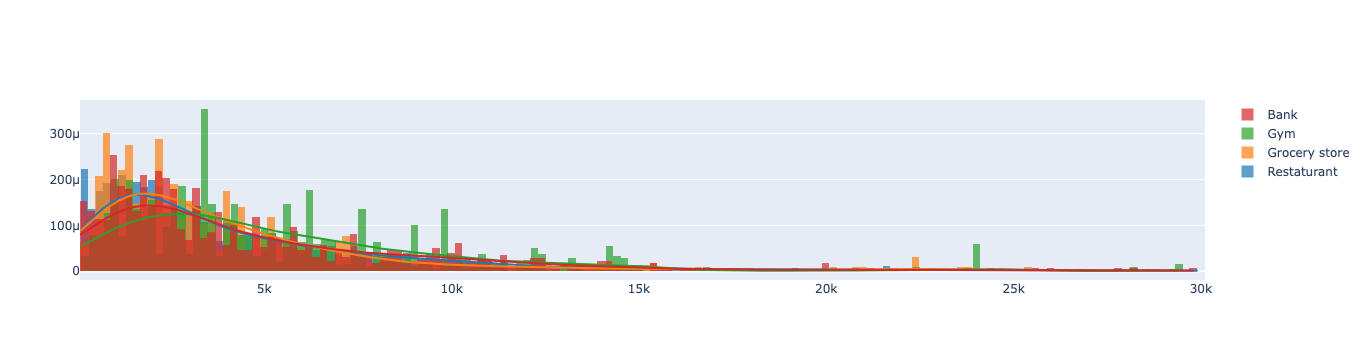

CPU times: user 195 ms, sys: 108 µs, total: 195 ms
Wall time: 194 ms


In [34]:
%%time
hist_data = [df_eating.dist.tolist(), df_grocery.dist.tolist(), df_gym.dist.tolist(), df_bank.dist.tolist()]
group_labels = ['Restaturant', 'Grocery store', 'Gym', 'Bank']
fig = ff.create_distplot(hist_data, group_labels,bin_size=200,show_rug=False)
fig.show()

# For all those people from high diversity CBG, how far they travel to their destinations
overall distance between home to high diversity destinations is shorter than to other destinations

In [23]:
%%time
df_select_di2 = df_visit_LA_merge[(df_visit_LA_merge['home_class_dominant']=='high diversity')]
print(df_select_di2.shape[0])

134736
CPU times: user 139 ms, sys: 18 µs, total: 139 ms
Wall time: 138 ms


In [24]:
df_select_di2.dist.describe()

count    134736.000000
mean     9641.372200  
std      14149.044866 
min      4.604256     
25%      2085.009068  
50%      4630.119653  
75%      10267.605780 
max      147819.306527
Name: dist, dtype: float64

In [37]:
df_select_di_30km2 = df_select_di2[df_select_di2['dist']<=30000]
print(df_select_di_30km2.shape[0])
df_eating2 = df_select_di_30km2[df_select_di_30km2['sic_code']==5812]
df_grocery2 = df_select_di_30km2[df_select_di_30km2['sic_code']==5411]
df_gym2 = df_select_di_30km2[df_select_di_30km2['sic_code']==7991]
df_bank2 = df_select_di_30km2[df_select_di_30km2['sic_code']==6021]

124316


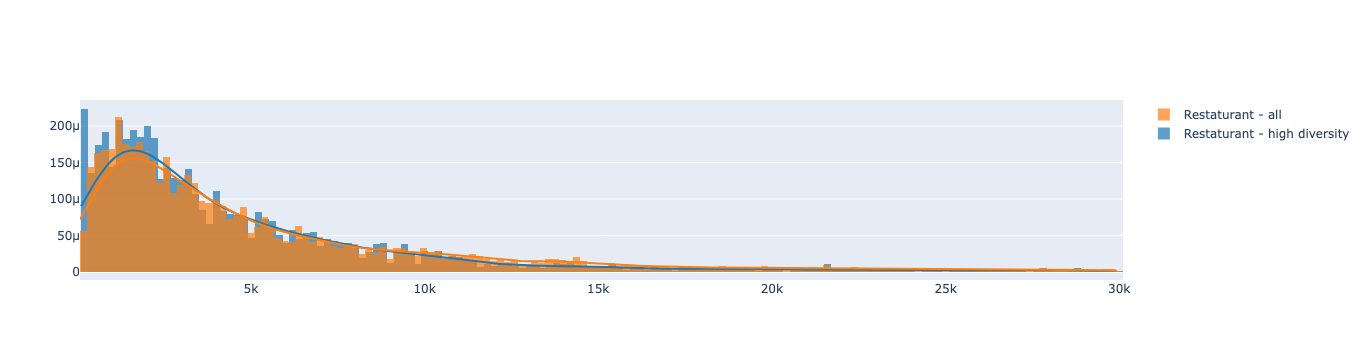

CPU times: user 509 ms, sys: 188 ms, total: 697 ms
Wall time: 498 ms


In [40]:
%%time
hist_data2 = [df_eating.dist.tolist(), df_eating2.dist.tolist()]
group_labels2 = ['Restaturant - high diversity', 'Restaturant - all']
fig2 = ff.create_distplot(hist_data2, group_labels2,bin_size=200,show_rug=False)
fig2.show()

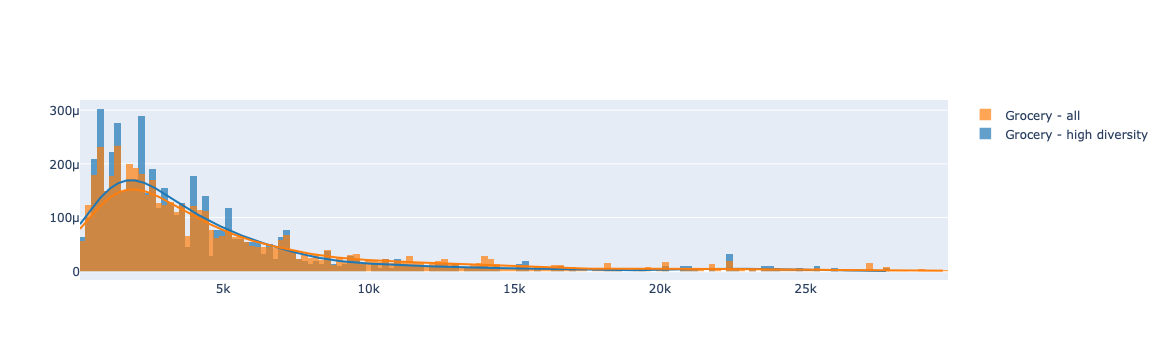

CPU times: user 73.1 ms, sys: 0 ns, total: 73.1 ms
Wall time: 71.5 ms


In [41]:
%%time
hist_data2 = [df_grocery.dist.tolist(), df_grocery2.dist.tolist()]
group_labels2 = ['Grocery - high diversity', 'Grocery - all']
fig2 = ff.create_distplot(hist_data2, group_labels2,bin_size=200,show_rug=False)
fig2.show()

# Asian

In [25]:
%%time
df_select_di3 = df_visit_LA_merge[(df_visit_LA_merge['home_class_dominant']=='R_Asian_moderate diversity')&
                                 (df_visit_LA_merge['class_dominant']=='high diversity')]
print(df_select_di3.shape[0])

32160
CPU times: user 185 ms, sys: 0 ns, total: 185 ms
Wall time: 183 ms


In [26]:
df_select_di3.dist.describe()

count    32160.000000 
mean     8241.587990  
std      10696.548296 
min      55.799511    
25%      2161.009578  
50%      4629.768469  
75%      9013.097846  
max      113866.040011
Name: dist, dtype: float64

In [49]:
df_select_di_30km3 = df_select_di3[df_select_di3['dist']<=30000]
print(df_select_di_30km3.shape[0])
df_eating3 = df_select_di_30km3[df_select_di_30km3['sic_code']==5812]
df_grocery3 = df_select_di_30km3[df_select_di_30km3['sic_code']==5411]
df_gym3 = df_select_di_30km3[df_select_di_30km3['sic_code']==7991]
df_bank3 = df_select_di_30km3[df_select_di_30km3['sic_code']==6021]

30195


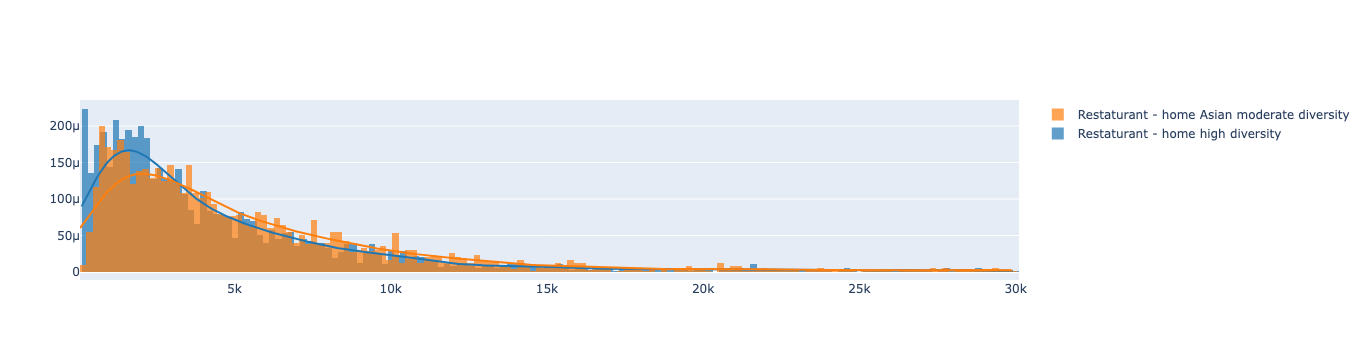

CPU times: user 176 ms, sys: 0 ns, total: 176 ms
Wall time: 175 ms


In [50]:
%%time
hist_data3 = [df_eating.dist.tolist(), df_eating3.dist.tolist()]
group_labels3 = ['Restaturant - home high diversity', 'Restaturant - home Asian moderate diversity']
fig3 = ff.create_distplot(hist_data3, group_labels3,bin_size=200,show_rug=False)
fig3.show()